# Task 3. Label Placement

Implement the first variation of this task - no more than two placement options for each label and implement your own 2-SAT solver.

Special thanks to Igor Dyachenko (@diht2016) for providing test input files! 

Importing required libraries:

In [1]:
import networkx as nx
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle

Color generator for painting bounding box:

In [2]:
def color_generator():
    i = 0
    while True:
        yield plt.rcParams['axes.prop_cycle'].by_key()['color'][i]
        i = (i+1) % 10

Bounding Box class. Has methods for checking the intersection of two bounding boxes and the crossing of the canvas boundaries by the bounding box:

In [3]:
class Box:
    def __init__(self, left_bottom, right_top):
        self.a = left_bottom
        self.b = right_top
    
    def intersects(self, other):
        if self.b[0] < other.a[0] or other.b[0] < self.a[0]:
            return False

        if self.b[1] < other.a[1] or other.b[1] < self.a[1]:
            return False

        return True

    def cross_borders(self, min_coords, max_coords):
        return any([
            self.a[0] < min_coords[0],
            self.a[1] < min_coords[1], 
            self.b[0] > max_coords[0], 
            self.b[1] > max_coords[1]
        ])

Point class. Has methods for finding intersections of two point bounding boxes, intersections of point bounding box and canvas boundaries, and displaying a point: 

In [4]:
class Point:
    def __init__(self, coords, box_size, box_pos_list):
        self.coords = coords
        self.box_size = box_size
        self.boxes = []
        self.value = None

        for box_pos in box_pos_list:
            a = [coords[i] - box_pos[i] for i in range(2)]
            b = [coords[i] - box_pos[i] + box_size[i] for i in range(2)]
            self.boxes.append(Box(a, b))

    
    def find_p2p_conflicts(self, other):
        conflicts = []
        for i, self_box in enumerate(self.boxes):
            for j, other_box in enumerate(other.boxes):
                if self_box.intersects(other_box):
                    conflicts.append((i, j))
        return conflicts

    def find_border_conflicts(self, min_coords, max_coords):
        conflicts = []
        for i, box in enumerate(self.boxes):
            if box.cross_borders(min_coords, max_coords):
                conflicts.append(i)
        return conflicts

    def plot(self, ax, color):
        ax.scatter([self.coords[0]], [self.coords[1]])
        box = self.boxes[self.value]
        width = box.b[0]-box.a[0]
        height = box.b[1]-box.a[1]

        box = Rectangle(
            box.a,
            width,
            height,
            facecolor='none',
            edgecolor=color,
            lw=1
        )
        ax.add_patch(box)

Main class for label placement:

In [5]:
class LabelPlacer:
    def __init__(self, 
            filename,
            limit=None,
            min_coords=[0, 0],
            max_coords=[500,500]):
        self.points = self.read_input(filename, limit=limit)
        self.min_coords = min_coords
        self.max_coords = max_coords
        self.G = nx.DiGraph()
        for i in range(len(self.points)):
            self.G.add_node(i + 1)
            self.G.add_node(-i - 1)
        self.colorgen = color_generator()

    def calc_places(self):
        """Label placement choice method"""
        p2p_conflicts = self.find_p2p_conflicts()
        border_conflicts = self.find_border_conflicts()

        self.create_graph_edges(p2p_conflicts, border_conflicts)
        scc = self.make_scc()
        self.G_condensed = nx.condensation(self.G, scc)
        self.solvable = self.check_sat()
        if self.solvable:        
            scc_to_sorted = self.top_sort_condensed()
            self.reassign_scc_nums(scc_to_sorted)
            self.assign_values()
        else:
            print('No solution!')

    def read_input(self, filename, limit=None):
        points = []
        with open(filename, 'r') as f:
            lines = f.readlines()
            if limit is not None:
                lines = lines[:limit]
            for line in lines:
                data = line.strip('\n').split('\t')
                coords = list(map(int, data[0].split(',')))
                box_size = list(map(int, data[1].split(',')))
                box_pos = [
                    list(map(int, item.split(','))) for item in data[2].split(' ')
                ]
                points.append(Point(coords, box_size, box_pos))
        return points

    def find_p2p_conflicts(self):
        """Find conflicts between two points"""
        p2p_conflicts = []
        for i in range(len(self.points)-1):
            for j in range(i+1, len(self.points)):
                conflicts = self.points[i].find_p2p_conflicts(self.points[j])
                if len(conflicts) > 0:
                    p2p_conflicts.append((i + 1, j + 1, conflicts))
        return p2p_conflicts

    def find_border_conflicts(self):
        """Find conflicts between points and canvas boundaries"""
        border_conflicts = []
        for i in range(len(self.points)):
            conflicts = self.points[i].find_border_conflicts(
                self.min_coords,
                self.max_coords
            )
            border_conflicts.append((i+1, conflicts))
        return border_conflicts

    def create_graph_edges(self, p2p_conflicts, border_conflicts):
        """Create implication graph"""
        for i, j, conflicts in p2p_conflicts:
            for state_i, state_j in conflicts:
                mask_i = 2*state_i - 1  # Map [0,1] to [-1;1]
                mask_j = 2*state_j - 1  # Map [0,1] to [-1;1]
                self.G.add_edge(mask_i*i, -mask_j*j)
                self.G.add_edge(mask_j*j, -mask_i*i)
        for i, conflicts in border_conflicts:
            for state in conflicts:
                mask = 2*state - 1
                self.G.add_edge(mask*i, -mask*i)

    def make_scc(self):
        """Find strong connection components"""
        scc = list(nx.kosaraju_strongly_connected_components(self.G))
        for i, nodes in enumerate(scc):
            for node in nodes:
                self.G.nodes[node]['scc'] = i
        return scc

    def check_sat(self):
        """Checking the system's resolvability"""
        num_points = len(self.G.nodes) // 2
        for i in range(num_points):
            if self.G.nodes[i + 1]['scc'] == self.G.nodes[-i - 1]['scc']:
                return False
        return True

    def top_sort_condensed(self):
        """Run top sort of a condensed graph"""
        scc_to_sorted = {}
        for i, node in enumerate(nx.topological_sort(self.G_condensed)):
            scc_to_sorted[node] = i
        return scc_to_sorted

    def reassign_scc_nums(self, scc_to_sorted):
        """Renumerate strong connection components according to top sort"""
        for node in self.G.nodes:
            self.G.nodes[node]["scc"] = scc_to_sorted[self.G.nodes[node]["scc"]]
    
    def assign_values(self):
        """Find value for bounding boxes"""
        num_points = len(self.G.nodes) // 2
        for i in range(num_points):
            self.points[i].value = int(self.G.nodes[i + 1]['scc'] > self.G.nodes[-i - 1]['scc'])

    def plot_points(self):
        """Plot points and bounding boxes"""
        if self.solvable:
            fig, ax = plt.subplots(figsize=(10, 10))
            ax.set_title("Label Placement")
            for i, point in enumerate(self.points):
                point.plot(ax, next(self.colorgen))
                ax.annotate(str(i+1), point.coords)
            plt.show()

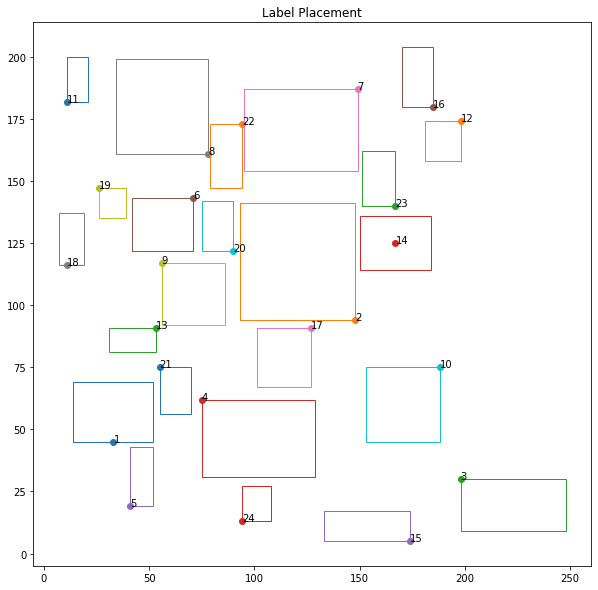

In [7]:
lp = LabelPlacer(filename="inputs/task3_bin1.txt")
lp.calc_places()
lp.plot_points()